## Introduction

This code is intended to be an answer to exercise 6.9 on [Sutton and Barto's book](http://incompleteideas.net/book/the-book-2nd.html). This exercise aims to take an agent from start to finish through a grid in the lowest amount of steps. In the original problem, the agent could only move if four directions: up, down, left, or right. In this case, the agent can move in eight directions: the original four, plus the four diagonal directions. Additionally, certain cells are affected by wind: when the agent stands in one of those cells, it's moved upward by a number of cells defined by the strength of the wind.  

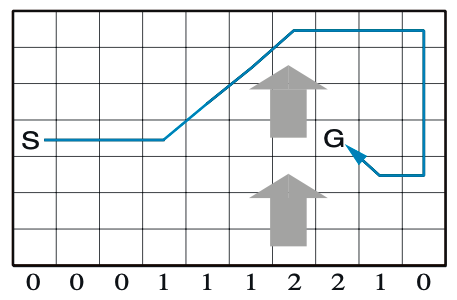

To get a better idea of the problem, the figure above shows the task at hand: the agent must find a way to go from S to G in the lowest steps possible, taking into account that some cells have wind. The strength of the wind is given by the numbers below the grid. You can find this image and a further explanation of the problem in page 130 of Sutton and Barto's [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).

In [36]:
# Alvaro Romo

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [37]:
# This code was made by modifying ShangtongZhang's original code:

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [38]:
# The main difference is the fact that this code implements gridworld with diagonal moves, not only vertical
# and horizontal moves. 

In [39]:
# Creating gridworld

height = 7
width = 10
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] # for each of the 10 columns

# Possible actions: 8
up = 0
down = 1
left = 2
right = 3
up_left = 4
up_right = 5
down_left = 6
down_right = 7

# Optional action: stay still, just move with the wind
no_action = 8

# Actions 
actions = np.arange(8)
actions_full = np.arange(9) # inlcuding no movement

# Start and finish
start = [3,0]
goal = [3,7]


In [40]:
def take_action(state, action):
    # state: [i,j] coordinates of where the agent is standing
    i, j = state
    if action == up:
        return [max(i - 1 - wind[j], 0), j]
    elif action == down:
        return [max(min(i + 1 - wind[j], height-1),0), j]
    elif action == left:
        return [max(i - wind[j], 0), max(j-1, 0)]
    elif action == right:
        return [max(i - wind[j], 0), min(j + 1, width - 1)]
    elif action == up_left:
        return [max(i-1-wind[j], 0), max(j-1, 0)]
    elif action == up_right:
        return [max(i-1-wind[j], 0), min(j + 1, width - 1)]
    elif action == down_left:
        return [max(min(i + 1 - wind[j], height - 1),0), max(j-1, 0)]
    elif action == down_right:
        return [max(min(i + 1 - wind[j], height - 1), 0), min(j + 1, width - 1)]
    elif action == no_action:
        return state
    

To solve this problem, the Q-learning (Watkins, 1989) algorithmn is used. This algorithm tries to estimate $q_{*}(s,a)$ to find an optimal policy $\pi{*}(s)$ for each state $s$. Unlike Monte Carlo methods, Q-learning belongs to a class of methods called Temporal Difference Learning methods, in which the update for the estimation of $q_{*}(s,a)$, given by $Q(s,a)$, is made on a step by step basis, not on an episode by episode basis.

In [56]:
def q_learning(episodes=100000, epsilon=0.1, alpha=0.5, gamma=1, no_move = False):
    # no-move: if true, the agent can stay still and just be moved by the wind
    if no_move:
        actions = np.arange(9)
    else:
        actions = np.arange(8)
        
    # Initialize Q(s,a) for all state-action pairs
    q_values = np.random.random(size = (height, width, len(actions)))
    
    # Loop over each episode
    rewards_log = []
    for episode in tqdm(range(episodes)):
        rewards = 0.0
        state = start
        while state != goal: # goal = terminal state
            # Choose an action based on an epsilon-greedy policy using q_values:
            if np.random.binomial(1, epsilon) == 1:
                action = np.random.choice(actions)
            else:
                max_q = np.max(q_values[state[0], state[1], :])
                values = q_values[state[0], state[1], :]
                action = np.random.choice(np.flatnonzero(values == max_q))
                
            next_state = take_action(state, action)
            reward = -1
            rewards += reward
            q_values[state[0], state[1], action] += alpha*(reward + gamma*np.max(q_values[next_state[0], next_state[1],:])-
                                                          q_values[state[0], state[1], action])
            state = next_state
        rewards_log.append(rewards)
            
    return q_values, rewards_log
    

In [57]:
Q, re = q_learning()
Q2, re2 = q_learning(no_move = True)

100%|██████████| 100000/100000 [00:33<00:00, 3008.14it/s]


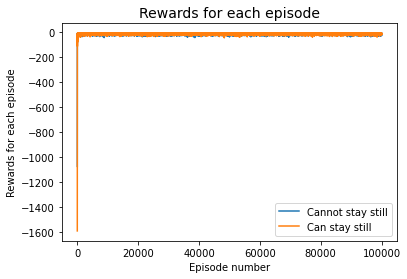

On average, with diagonal moves allowed, the agent takes 9.30639 steps to reach the goal
On average, with diagonal moves and standing still allowed, the agent takes 9.15294 steps to reach the goal


In [72]:
plt.plot(np.arange(100000), re, label = 'Cannot stay still')
plt.plot(np.arange(100000), re2, label = 'Can stay still')
plt.title('Rewards for each episode', size = 14)
plt.xlabel('Episode number')
plt.ylabel('Rewards for each episode')
plt.legend()
plt.show()

mean_re = np.mean(re)
mean_re2 = np.mean(re2)

print('On average, with diagonal moves allowed, the agent takes {} steps to reach the goal'.format(abs(mean_re)))
print('On average, with diagonal moves and standing still allowed, the agent takes {} steps to reach the goal'.format(abs(mean_re2)))
      
      
      

### Final note

If we allow the agent to move diagonally, the average amount of steps needed for the agent to reach the goal decreases, compared with the case that the agent could only move in four directions. In fact, if the agent could only move up, down, left, or right, this same algorithm achieved an average of 17 steps to reach the goal. However if we allow the agent to move diagonally, and even don't move at all, the average steps needed to reach the goal decreases to approximately 9 steps. 

Note: The number of steps needed for each episode is given by the total rewards of an episode. Since each step an agent does not reach the goal the reward is -1, the sum of rewards represents the number of steps needed to reach the goal. 